## Importing packages

In [1]:
from __future__ import print_function
import six
import os  # needed navigate the system to get the input data
import radiomics
from radiomics import featureextractor  # This module is used for interaction with pyradiomics
from PIL import Image
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage


# Base directories and parameters

In [2]:
# define the path to the base output directory
BASE_OUTPUT = "output"
MAIN_LESION_FOLDER = os.path.join(BASE_OUTPUT, "categories\\")
LESION_FOLDERS = [name for name in os.listdir(MAIN_LESION_FOLDER) if os.path.isdir(os.path.join(MAIN_LESION_FOLDER, name))]

# Instantiate the extractor
params = 'Params.yaml'


## Feature extraction

In [3]:
extractor = featureextractor.RadiomicsFeatureExtractor(params)
results = []

for folder in LESION_FOLDERS:
    # Load up the segmentations, 50 from each lesion category folder(9*50)
    for iter in range(0, 50):
        path_original = os.path.join(MAIN_LESION_FOLDER, folder, "originals\\", 'original_' + str(iter) + '.png')
        path_label = os.path.join(MAIN_LESION_FOLDER, folder, "labels\\", 'label_' + str(iter) + '.png')
        original = sitk.ReadImage(path_original)
        label = sitk.ReadImage(path_label)
        result = extractor.execute(original, label)
        results.append(result)
    

## Calculating mean value for each feature 

In [4]:
def dict_mean(dict_list):
    mean_dict = {}
    for key in dict_list[0].keys():
            if key.startswith("original_"):
                mean_dict[key] = sum(d[key] for d in dict_list) / len(dict_list)
    return mean_dict


actinic_karatosis = dict_mean(results[0: 50])
basal_cell_carcinoma = dict_mean(results[50: 100])
dermatofibroma = dict_mean(results[100: 150])
melanoma = dict_mean(results[150: 200])
nevus = dict_mean(results[200: 250])
pigmented_benign_keratosis = dict_mean(results[250: 300])
seborrheic_keratosis = dict_mean(results[300: 350])
squamous_cell_carcinoma = dict_mean(results[350: 400])
vascular_lesion = dict_mean(results[400: 450])


In [5]:
# hang on to all our features
features = {}

features[1] = actinic_karatosis
features[2] = basal_cell_carcinoma
features[3] = dermatofibroma
features[4] = melanoma
features[5] = nevus
features[6] = pigmented_benign_keratosis
features[7] = seborrheic_keratosis
features[8] = squamous_cell_carcinoma
features[9] = vascular_lesion

# A list of the valid features, sorted
feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), features[1] )))


In [6]:
# Make a numpy array of all the values
samples = np.zeros((9,len(feature_names)))
for case_id in range(1,10):
    a = np.array([])
    for feature_name in feature_names:
        a = np.append(a, features[case_id][feature_name])
    samples[case_id-1,:] = a
    
# May have NaNs
samples = np.nan_to_num(samples)


## Plot features as a heatmap

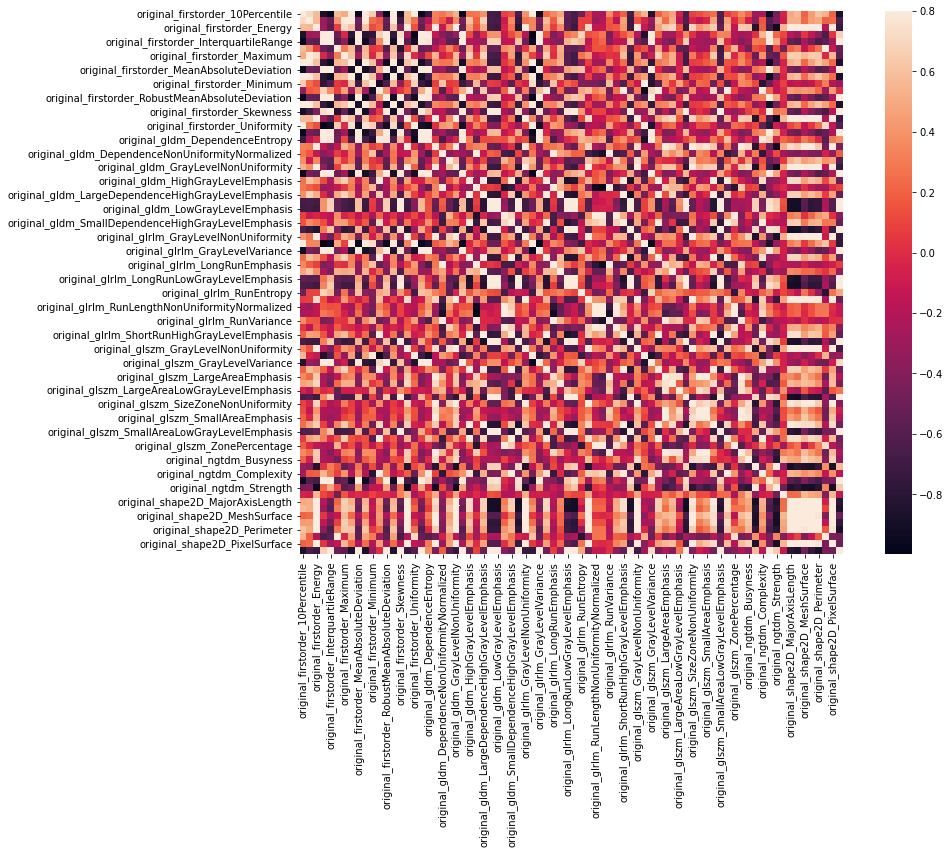

In [7]:
types =['actinic_karatosis', 'basal_cell_carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented_benign_keratosis', 'seborrheic_keratosis', 'squamous_cell_carcinoma', 'vascular_lesion']

# Construct a pandas dataframe from the samples
d = pd.DataFrame(data=samples, columns=feature_names, index=types)
corr = d.corr()

# Set up the matplotlib figure, make it big!
f, ax = plt.subplots(figsize=(15, 10))

# Draw the heatmap using seaborn
sns.heatmap(corr, vmax=.8, square=True)
plt.show()


## Cluster the heatmap 

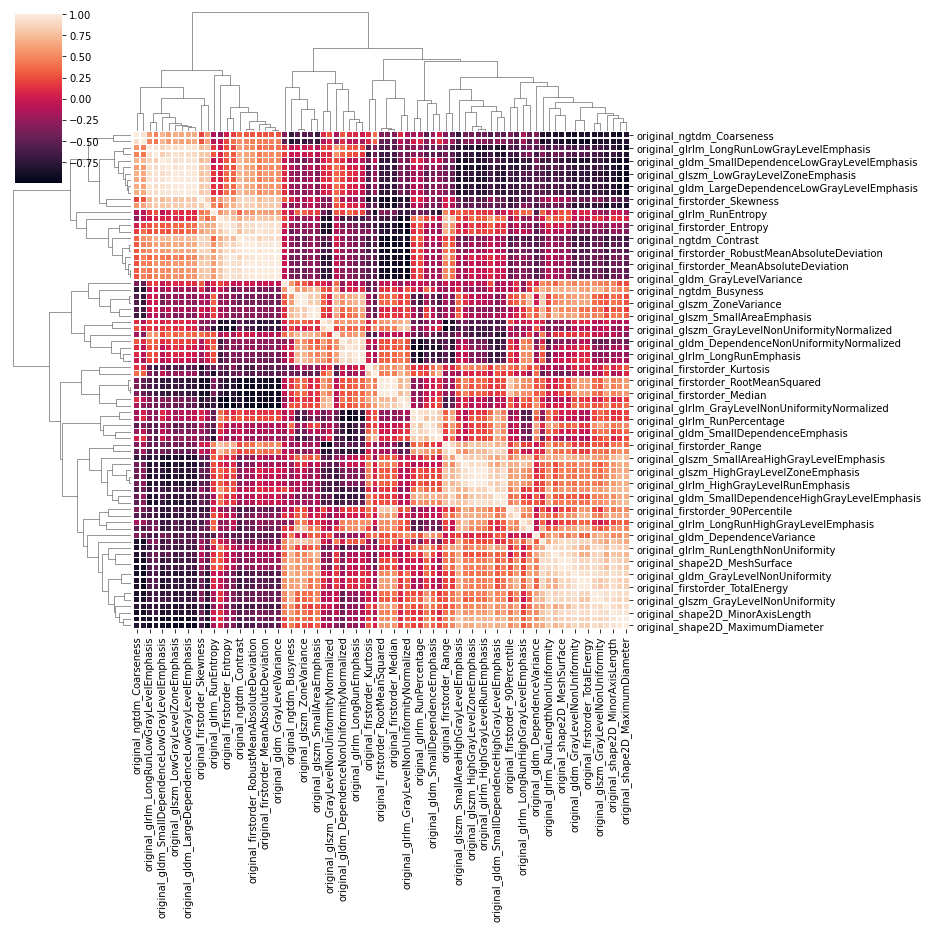

In [8]:
# Choose a subset of features for clustering
dd = d.iloc[:,1:79]

pp = sns.clustermap(dd.corr(), linewidths=.5, figsize=(13,13))
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)

plt.show()


In [9]:
m = d.values

Z = linkage(m,'ward')


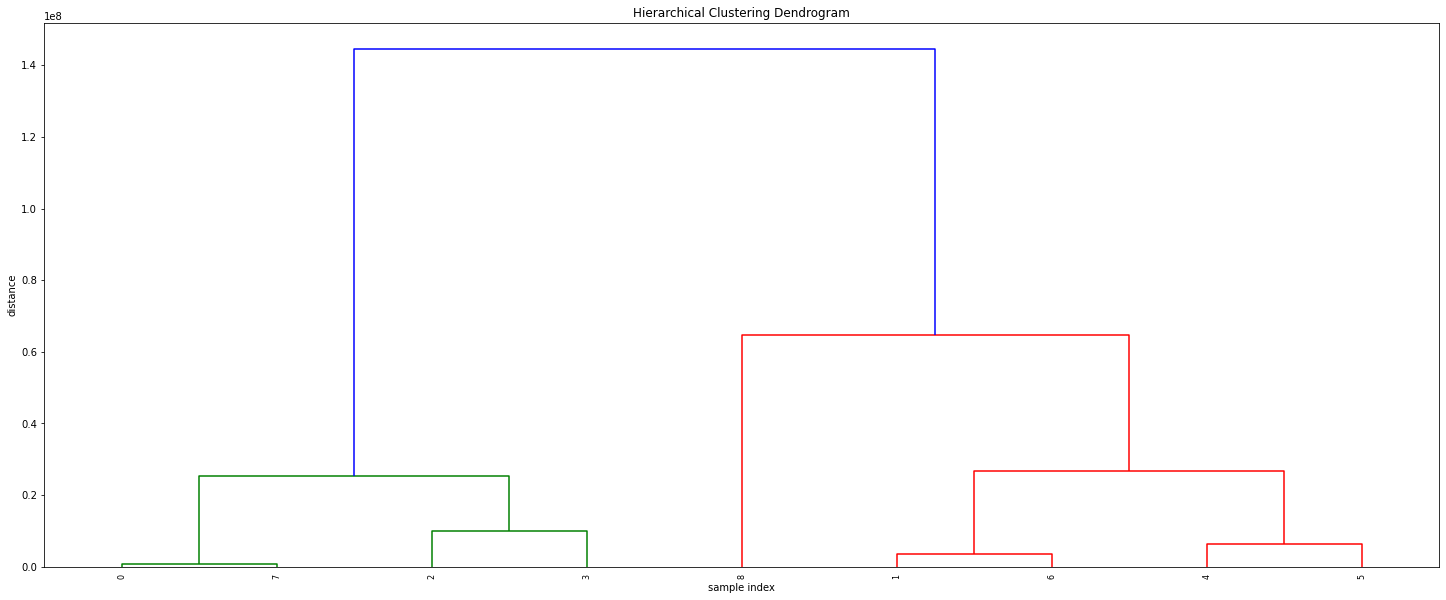

In [10]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()


In [11]:
d.head(9)


,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_ngtdm_Strength,original_shape2D_Elongation,original_shape2D_MajorAxisLength,original_shape2D_MaximumDiameter,original_shape2D_MeshSurface,original_shape2D_MinorAxisLength,original_shape2D_Perimeter,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity
actinic_karatosis,126.184,177.880,1.319715e+08,1.776536,27.650,3.988251,204.52,152.716603,16.359053,154.24,...,0.073596,0.702876,129.904600,143.735274,5465.00,91.574873,939.737995,0.207858,5468.24,0.309896
basal_cell_carcinoma,129.204,176.328,7.877670e+07,1.609028,25.180,4.993836,198.14,153.975944,15.148582,156.11,...,0.179358,0.593691,101.269453,113.539557,3313.53,60.596940,530.798353,0.232482,3316.12,0.425580
dermatofibroma,122.622,174.118,1.226095e+08,1.711683,29.140,2.730186,199.84,149.562056,16.181515,150.96,...,0.050983,0.686197,108.177713,113.768293,5179.40,74.387898,649.647133,0.137304,5180.58,0.461208
melanoma,90.658,169.876,1.155414e+08,2.125703,43.995,2.926514,201.44,128.610764,24.713689,127.15,...,0.089421,0.678428,123.196935,129.367543,6449.19,84.779632,647.621809,0.116040,6450.68,0.524078
nevus,97.466,169.348,8.859182e+07,2.011272,40.965,3.789017,195.96,131.821866,22.858781,130.50,...,0.118587,0.633748,109.658652,113.766074,4417.06,69.131757,575.879959,0.153828,4418.92,0.530530
pigmented_benign_keratosis,108.646,165.828,9.298725e+07,1.739960,33.875,2.797968,188.22,138.029849,18.310516,138.48,...,0.106189,0.665292,113.370936,121.703050,4695.62,74.325007,608.929059,0.160078,4697.50,0.445085
seborrheic_keratosis,103.092,177.340,7.620870e+07,2.028715,43.870,2.883347,200.06,139.098541,23.734997,137.56,...,0.142857,0.611271,107.642306,112.932871,3709.35,65.169635,510.349052,0.156406,3711.34,0.499210
squamous_cell_carcinoma,121.298,182.976,1.314907e+08,1.898048,33.560,3.362444,205.14,152.926057,19.340894,154.46,...,0.075131,0.677770,122.184891,126.866072,5282.62,81.844337,658.178301,0.132637,5283.84,0.428378
vascular_lesion,81.892,164.872,4.801515e+07,2.075773,51.270,2.611078,189.94,120.830800,26.883948,117.88,...,0.228527,0.677204,69.118276,77.688610,2572.95,45.003270,304.852267,0.155586,2573.82,0.673888


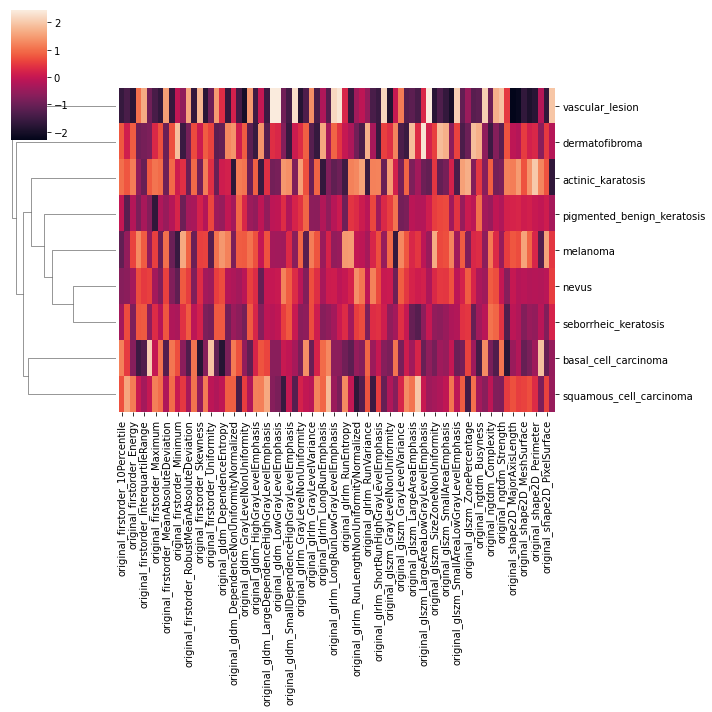

In [12]:
pp = sns.clustermap(d, col_cluster=False, metric='chebyshev', z_score=1)
_ = plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
plt.show()


In [17]:
df = pd.DataFrame(d)

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

                            original_firstorder_10Percentile  \
actinic_karatosis                                    126.184   
basal_cell_carcinoma                                 129.204   
dermatofibroma                                       122.622   
melanoma                                              90.658   
nevus                                                 97.466   
pigmented_benign_keratosis                           108.646   
seborrheic_keratosis                                 103.092   
squamous_cell_carcinoma                              121.298   
vascular_lesion                                       81.892   

                            original_firstorder_90Percentile  \
actinic_karatosis                                    177.880   
basal_cell_carcinoma                                 176.328   
dermatofibroma                                       174.118   
melanoma                                             169.876   
nevus                                  

In [ ]:
print(df.to_string())